In [30]:
#Going to try and explain my thought process here
#Importing Packages 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
#Defining function to read and process mutation files
    #Defensive programming to make sure the files are read properly 
    #And so that it'll tell me what the issue is if there is one 

def read_mutation_file(filepath):
    try:
        with open(filepath, 'r') as f:
            header = f.readline().strip().split('\t')
            data = f.readline().strip().split('\t')
        if len(data) < len(header):
            print(f"Error: File {filepath} has mismatched header and data colums")
            return None

#Creating dictionary 
        data_dict = {}
        data_dict['gene_name'] = data[0]
        data_dict['wt_sequence'] = data[1]
        data_dict['mut_sequence'] = data[2]

#Extracting the replicate data from triplicates by slicing
        data_dict['mrna_wt'] = [float(x) for x in data[3:6]]
        data_dict['mrna_mut'] = [float(x) for x in data[6:9]]
        data_dict['protein_wt'] = [float(x) for x in data[9:12]]
        data_dict['protein_mut'] = [float(x) for x in data[12:15]]
        data_dict['cell_viability_wt'] = [float(x) for x in data[15:18]]
        data_dict['cell_viability_mut'] = [float(x) for x in data[18:21]]

        return data_dict 
    except Exception as e:
        print(f"Error processing file {filepath}: {st(e)}")
        return None

In [38]:
#Creating a function to analyse the mutations
#And what type the mutation is 
def analyze_mutation(wt_seq, mut_seq):
    mut_type = ''
    if len(wt_seq) > len(mut_seq):
        mut_type = 'deletion'
    elif len(wt_seq) < len(mut_seq):
        mut_type = 'insertion'
    else:
        mut_type = 'substitution'

#Checking if the mutation is in the promoter region or coding region 
    mut_location = 'promoter' if any(wt_seq[i] != mut_seq[i] for i in range(1000)) else 'coding'

    return mut_type, mut_location


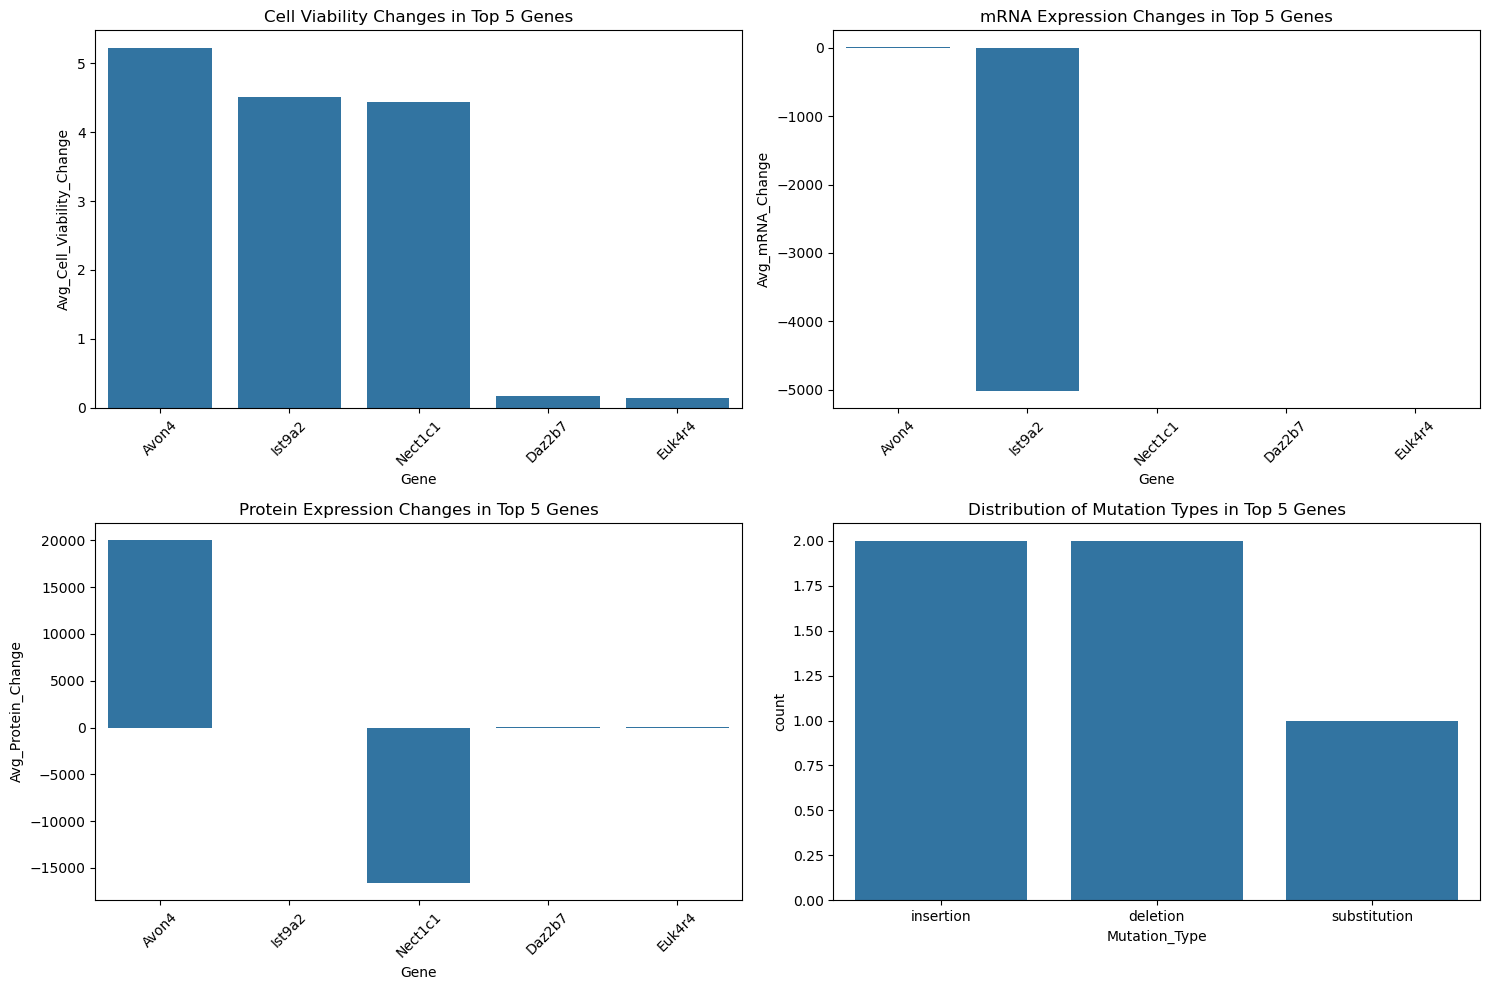


Top 5 Genes Summary:
       Gene Mutation_Type Mutation_Location  Avg_Cell_Viability_Change  \
47    Avon4     insertion          promoter                   5.215711   
20   Ist9a2      deletion          promoter                   4.514477   
31  Nect1c1      deletion          promoter                   4.436899   
6    Daz2b7  substitution          promoter                   0.170895   
9    Euk4r4     insertion          promoter                   0.135741   

    Avg_mRNA_Change  Avg_Protein_Change  
47         1.445566        20031.666667  
20     -5010.362690          -23.961772  
31        -0.743867       -16614.000000  
6          0.745162            8.666667  
9          0.006077            6.000000  


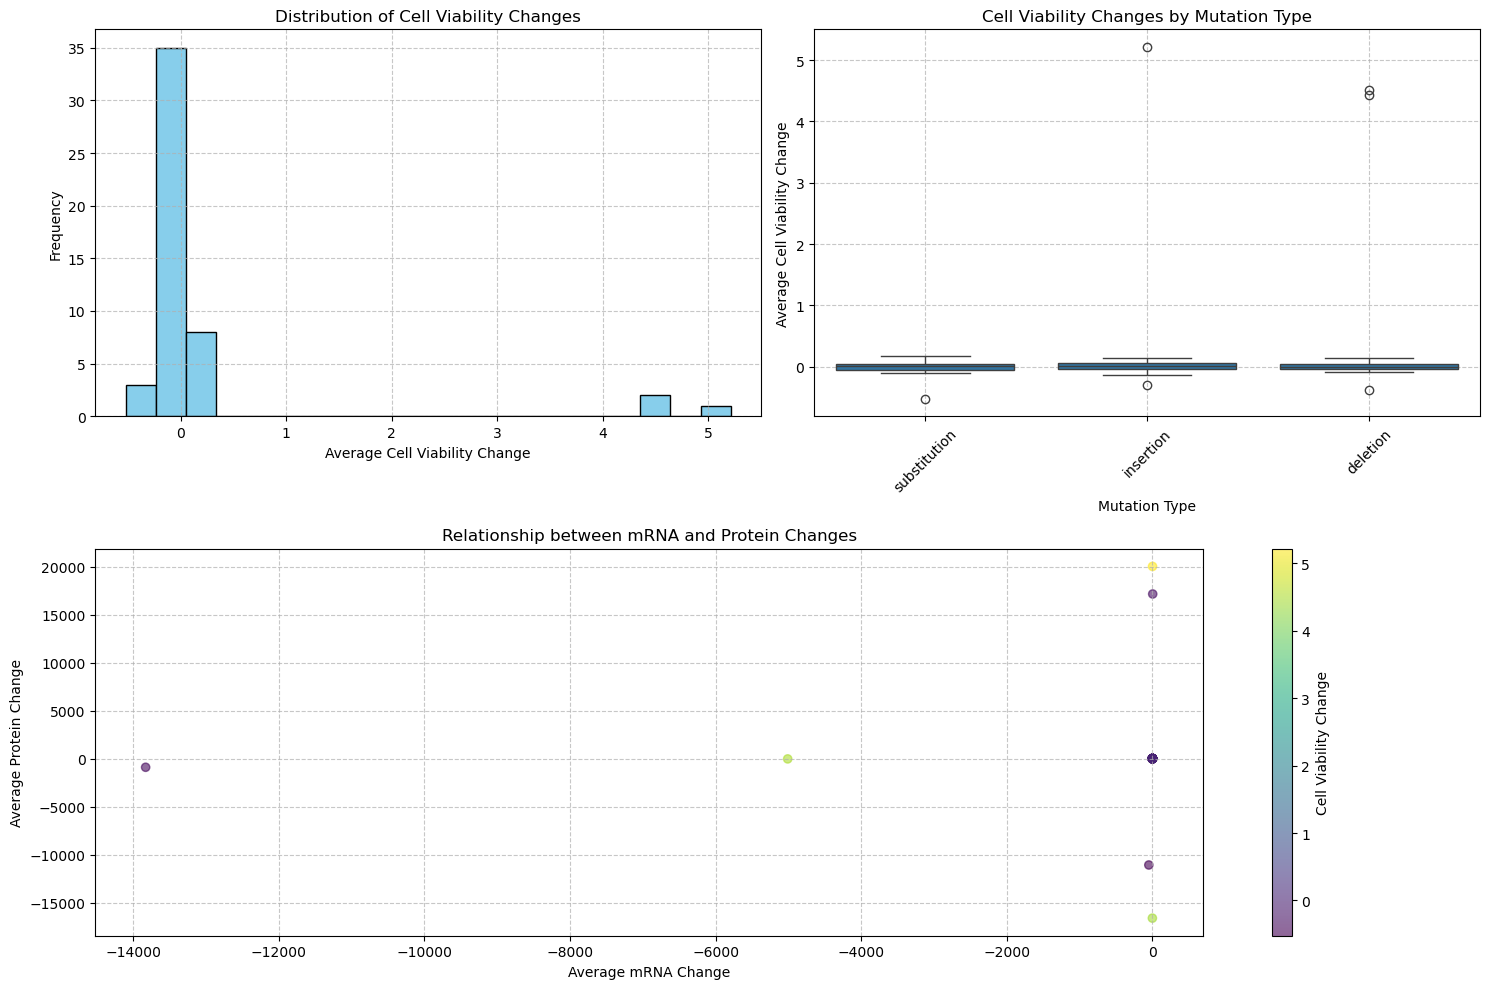

In [40]:
#Processing the files
#Filepath is specific to home laptop

mutation_data = []
data_path = r"C:\Users\kaitl\OneDrive\BIOCOMP_ASSESSMENT_FILES\mutations"

for file in os.listdir(data_path):
    if file.endswith('.txt'):
        filepath = os.path.join(data_path, file)
        data = read_mutation_file(filepath)
        
#Calculating averages and the changes 
        mut_type, mut_location = analyze_mutation(data['wt_sequence'], data['mut_sequence'])
        
        mutation_data.append({
            'Gene': data['gene_name'],
            'Mutation_Type': mut_type,
            'Mutation_Location': mut_location,
            'Avg_Cell_Viability_Change': np.mean(data['cell_viability_mut']) - np.mean(data['cell_viability_wt']),
            'Avg_mRNA_Change': np.mean(data['mrna_mut']) - np.mean(data['mrna_wt']),
            'Avg_Protein_Change': np.mean(data['protein_mut']) - np.mean(data['protein_wt'])
        })

#Creating a Data Frame 
df = pd.DataFrame(mutation_data)
top_5_genes = df.nlargest(5, 'Avg_Cell_Viability_Change')

#Visualisation , creating some graphs 
plt.figure(figsize=(15, 10))

#GRaph 1 - Cell viability Changes 
plt.subplot(2, 2, 1)
sns.barplot(data=top_5_genes, x='Gene', y='Avg_Cell_Viability_Change')
plt.title('Cell Viability Changes in Top 5 Genes')
plt.xticks(rotation=45)

#Graph 2 - mRNA Expression changes 
plt.subplot(2, 2, 2)
sns.barplot(data=top_5_genes, x='Gene', y='Avg_mRNA_Change')
plt.title('mRNA Expression Changes in Top 5 Genes')
plt.xticks(rotation=45)

#Graph 3 - Protein expression changes 
plt.subplot(2, 2, 3)
sns.barplot(data=top_5_genes, x='Gene', y='Avg_Protein_Change')
plt.title('Protein Expression Changes in Top 5 Genes')
plt.xticks(rotation=45)

#Graph 4 - Mutation Types Distrobution 
plt.subplot(2, 2, 4)
sns.countplot(data=top_5_genes, x='Mutation_Type')
plt.title('Distribution of Mutation Types in Top 5 Genes')

plt.tight_layout()
plt.show()

#Summary of top 5 genes 
print("\nTop 5 Genes Summary:")
print(top_5_genes[['Gene', 'Mutation_Type', 'Mutation_Location', 'Avg_Cell_Viability_Change', 
                   'Avg_mRNA_Change', 'Avg_Protein_Change']])

#Stick graphs together for report  
plt.figure(figsize=(15, 10))

#Top left
plt.subplot(2, 2, 1)
plt.hist(df['Avg_Cell_Viability_Change'], bins=20, color='skyblue', edgecolor='black')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Average Cell Viability Change')
plt.ylabel('Frequency')
plt.title('Distribution of Cell Viability Changes')

#Top right
plt.subplot(2, 2, 2)
sns.boxplot(x='Mutation_Type', y='Avg_Cell_Viability_Change', data=df)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Mutation Type')
plt.ylabel('Average Cell Viability Change')
plt.title('Cell Viability Changes by Mutation Type')
plt.xticks(rotation=45)      

#Bottom
plt.subplot(2, 1, 2)
scatter = plt.scatter(df['Avg_mRNA_Change'], df['Avg_Protein_Change'],
                     c=df['Avg_Cell_Viability_Change'], cmap='viridis',
                     alpha=0.6)
plt.colorbar(scatter, label='Cell Viability Change')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Average mRNA Change')
plt.ylabel('Average Protein Change')
plt.title('Relationship between mRNA and Protein Changes')


plt.tight_layout()

#Saving 
plt.savefig('combined_plots.png', dpi=300, bbox_inches='tight')
plt.show()           